In [1]:
import os
import pandas as pd
import numpy as np
import math
import scipy.integrate as integrate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as mticker
from scipy import interpolate
from scipy.integrate import odeint
from scipy.interpolate import griddata
from astropy.io import fits
from astropy.modeling import models
import pylab
import sys
import time
from scipy.optimize import minimize

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
##################################
# define some universal constant #
##################################

conv_factor_GeV_to_erg = 0.00160218
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56 * pow(10,6)
conv_factor_sec_to_yr = 1. / conv_factor_yr_to_sec
conv_factor_pc_to_m = 3.086*pow(10,16)
k_boltzmann = 8.617e-14                 # Boltzmann constant, in [GeV K^(-1)]
m_p = .939                              # proton mass in GeV/c^2
m_e = 0.000510998918                    # electron mass in GeV/c^2
D_0_yr = 0.65 * pow(10,24)/conv_factor_sec_to_yr
pi = math.pi
c = 2.99 * pow(10,8)                    # speed of light in [m sec^(-1)]
b_0_yr = 1.4 * pow(10,-16)/conv_factor_sec_to_yr

In [4]:
##################################################################
# define the parameters of the specific object I am considering #
##################################################################
    
considered_objects = 3
object_name = ['Sample 1','Sample 2','Sample 3'] 


gamma_inj = 2.4                        # spectral index of the source term Q
alpha_dec = [2., 2., 2.]               # decay index for the luminosity of the source
tau_dec = [1.e+5, 1.e+5, 1.e+5]        # timescale for the decay of the source-luminosity, in [yr]
r_kpc = [0.35, 0.35, 0.35]             # distance of the source in kiloparsec, to be converted in [m] to match the units of the function J_e(E)
N_0 = 1.e+39                           # normalization, to compute the energy budget
object_age = [1.5e+5, 2.e+5, 2.5e+5]   # age, in [yr]
  

r = np.zeros(considered_objects)
multiplot_color = ['red','blue','green']


# In the following lines I define the energy range of interest and its binning, in [GeV]
start = 1.0
stop = 100000.0
steps = 200    # 1000, to make the low-energy wiggles disappear
print ("The number of energy points is", steps)

E_e = np.logspace(np.log10(start), np.log10(stop), num=steps, endpoint=True)

The number of energy points is 200


# <center>Energy loss rate, with Klein-Nishina correction
    
$$
\begin{align}
& b(E) \equiv \frac{dE}{dt} = - \frac{4}{3} \sigma_T c \left[ f^{KN}_{i} U_i + U_B \right] \, \left( \frac{E}{m_e c^2} \right)^2 \\[10 pt]
& f^{KN}_{i} = \frac{ \frac{45}{64 \pi^2} \left( \frac{m_e c^2}{k_B T_i} \right)^2 }{ \frac{45}{64 \pi^2} \left( \frac{m_e c^2}{k_B T_i} \right)^2 + \left( \frac{E}{m_e c^2} \right)^2 }
\end{align}
$$

Initial condition, in [GeV]: 1.000000e+09
min(time_ODE): 1.0 , max(time_ODE): 2499999999.9999995

time_ODE: [1.00000000e+00 1.00021642e+00 1.00043289e+00 ... 2.49891825e+09
 2.49945906e+09 2.50000000e+09]
min(ODE_sol_array): 0.0980180813693678 , max(ODE_sol_array): 1000000000.0


/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


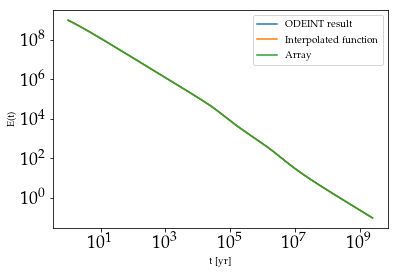

In [5]:
#### Building the Klein-Nishina loss curve ####


### Klein-Nishina factor, from Evoli et al. arXiv:2007.01302 (2020) ###
#######################################################################
ISRF_components = ['IR', 'OPT', 'UV_1', 'UV_2', 'UV_3']
T_ISRF = [33.07, 313.32, 3249.3, 6150.4, 23209.0]          # in [K]
U_ISRF = [0.25e-9, 0.055e-9, 0.37e-9, 0.23e-9, 0.12e-9]    # energy density of the contributions, in [GeV cm^(-3)]
U_B = 0.25e-9                                              # energy density of the magnetic field, in [GeV cm^(-3)]
sigma_Thomson = 6.65e-25                                   # in [cm^2]
c_cm = 2.99e+10/conv_factor_sec_to_yr                      # speed of light, in [cm yr^(-1)]

factor_ratio = ( 45 / (64*np.pi**2) )


def loss_rate_KN_ODE(Energy, time):
    
    f_KN_times_U = 0.
    for i in range (len(T_ISRF)):

        f_KN_times_U_single = ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) / ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) + (Energy/m_e)**2 ) ) * U_ISRF[i]
        f_KN_times_U = f_KN_times_U + f_KN_times_U_single
        
    dE_dt_KN = - (4/3) * (sigma_Thomson * c_cm) * (f_KN_times_U + U_B) * (Energy/m_e)**2
    return dE_dt_KN


def loss_rate_KN(Energy):
    
    f_KN_times_U = 0.
    
    for i in range (len(T_ISRF)):

        f_KN_times_U_single = ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) / ( (factor_ratio * ( m_e / (k_boltzmann*T_ISRF[i]) )**2) + (Energy/m_e)**2 ) ) * U_ISRF[i]
        f_KN_times_U = f_KN_times_U + f_KN_times_U_single
        
    dE_dt_KN = - (4/3) * (sigma_Thomson * c_cm) * (f_KN_times_U + U_B) * (Energy/m_e)**2
    return dE_dt_KN
#######################################################################


max_time = (max(object_age)*1.e+4)      # in [yr]


# Initial condition
E0 = 1.e+9
print ("Initial condition, in [GeV]:", "{:e}".format(E0))

# time points
time_ODE = np.logspace(np.log10(1.), np.log10(max_time), num=1.e+5)    # in [sec]
print ("min(time_ODE):", min(time_ODE), ", max(time_ODE):", max(time_ODE))
print ("")
print ("time_ODE:", time_ODE)



# solve ODE
ODE_sol = odeint(loss_rate_KN_ODE, E0,time_ODE)
#print (ODE_sol[:,0])

# interpolate the solution array
ODE_sol_func = interpolate.interp1d(time_ODE, ODE_sol[:,0], kind='cubic')

# put the function into a numpy array
ODE_sol_array = ODE_sol_func(time_ODE)

print ("min(ODE_sol_array):", min(ODE_sol_array), ", max(ODE_sol_array):", max(ODE_sol_array))


# plot results
plt.plot(time_ODE, ODE_sol, label='ODEINT result')
plt.plot(time_ODE, ODE_sol_func(time_ODE), label='Interpolated function')
plt.plot(time_ODE, ODE_sol_array, label='Array')

plt.legend()
plt.xlabel('t [yr]')
plt.ylabel('E(t)')
plt.xscale('log')
plt.yscale('log')

# <center>SNR evolution timescales

$$
\begin{align}
&\bullet \hspace{0.5cm} t_{\mathrm{Sed, kyr}}  =  0.3 E_\mathrm{SNR,51}^{-1/2} M_{\mathrm{ej},\odot} n_{T,1}^{-1/3} \\[10 pt]
&\bullet \hspace{0.5cm} t_{\mathrm{PDS, kyr}}  =  \frac{36.1 e^{-1} E_\mathrm{SNR,51}^{3/14}}{\xi_n^{5/14} n_{T,1}^{4/7}} \\[10 pt]
&\bullet \hspace{0.5cm} t_{\mathrm{MCS, kyr}}  =  \mathrm{min} \left[ \frac{61 v_\mathrm{ej,8}^3}{\xi_n^{9/14} n_{T,1}^{3/7} E_\mathrm{SNR,51}^{3/14}}, \frac{476}{(\xi_n \Phi_c)^{9/14}} \right] t_\mathrm{PDS, kyr} \\[10 pt]  &\bullet \hspace{0.5cm} t_{\mathrm{merge, kyr}} =  153 \left(\frac{E_\mathrm{SNR,51}^{1/14} n_{T,1}^{1/7} \xi_n^{3/14}}{\beta C_{06}} \right)^{10/7} t_\mathrm{MCS, kyr}
\end{align}
$$

In [6]:
#### Block to compute the SNR evolution-timescales ####


## Source parameters ##
E_SNR = 1.    # total energy budget of the SNR, in units [10^51 erg]
M_ej = 1.     # in units [1 solar masses]
n_T = 10.     # in units [1 cm^{-3}]
csi_n = 1.    # ambient medium metallicity
v_ej = 10.    # in units [10^8 cm/s]
phi_c = 1.    # thermal plasma conductivity
beta = 2. 
C_06 = 1.

## Timescales, calculated in [kyr] ##
t_Sed_kyr = 0.3 * E_SNR**(-1/2) * M_ej * n_T**(-1/3)
t_PDS_kyr = ( (36.1/np.exp(1)) * E_SNR**(3/14) ) / (csi_n**(5/14) * n_T**(4/7))
t_MCS_kyr = min( (61 * v_ej**3) / ( csi_n**(9/14) * n_T**(3/7) * E_SNR**(3/14) ), 476 / (csi_n * phi_c)**(9/14) ) * t_PDS_kyr
t_merge_kyr = 153 * ( ( E_SNR**(1/14) * n_T**(1/7) * csi_n**(3/14) ) / (beta * C_06) )**(10/7) * t_MCS_kyr


f = mticker.ScalarFormatter(useMathText=False)
f.set_powerlimits((-5,5))


print ("With n_T =", n_T)
print ("")
print ("t_Sed:", t_Sed_kyr, "[kyr] =", "{}".format(f.format_data( t_Sed_kyr*1000. )), "[yr]")
print ("")
print ("t_PDS:", t_PDS_kyr, "[kyr] =", "{}".format(f.format_data( t_PDS_kyr*1000. )), "[yr]")
print ("")
print ("t_MCS:", t_MCS_kyr, "[kyr] =", "{}".format(f.format_data( t_MCS_kyr*1000. )), "[yr]")
print ("")
print ("t_merge:", t_merge_kyr, "[kyr] =", "{}".format(f.format_data( t_merge_kyr*1000. )), "[yr]")
print ("")

With n_T = 10.0

t_Sed: 0.13924766500838337 [kyr] = 1.3924766501{\times}10^{2} [yr]

t_PDS: 3.5627401543017463 [kyr] = 3.5627401543{\times}10^{3} [yr]

t_MCS: 1695.8643134476313 [kyr] = 1.6958643134{\times}10^{6} [yr]

t_merge: 154213.11645933276 [kyr] = 1.5421311646{\times}10^{8} [yr]



In [7]:
## Time arrays ##

time_start = t_Sed_kyr
time_stop = t_merge_kyr
t_range_release = np.logspace(np.log10(time_start), np.log10(time_stop), num=len(E_e))  # in [kyr]


t_range_Sed_index = np.argmin(abs(t_Sed_kyr - t_range_release))
t_range_PDS_index = np.argmin(abs(t_PDS_kyr - t_range_release))
t_range_MCS_index = np.argmin(abs(t_MCS_kyr - t_range_release))
t_range_merge_index = np.argmin(abs(t_merge_kyr - t_range_release))

# <center> Escape-energy time-evolution for Electrons
    
$$
\begin{align}
&\bullet \hspace{0.5cm} E_{\mathrm{esc, Geo, 0}} = E_{\mathrm{M}} (t_{\mathrm{Sed}}) \left( \frac{t}{t_{\mathrm{Sed}}} \right)^{-11/10} \\[10pt]
&\bullet \hspace{0.5cm} E_{\mathrm{esc, Geo, 1}} = E_{\mathrm{M}} (t_{\mathrm{PDS}}) \left( \frac{t}{t_{\mathrm{PDS}}} \right)^{-11/10} = E_{\mathrm{esc, Cur}} (t_{\mathrm{PDS}}) \left( \frac{t}{t_{\mathrm{PDS}}} \right)^{-11/10}\\[10pt]
&\bullet \hspace{0.5cm} E_{\mathrm{esc, Geo, 2}} = E_{\mathrm{M}} (t_{\mathrm{MCS}}) \left( \frac{t}{t_{\mathrm{MCS}}} \right)^{-5/4} = E_{\mathrm{esc, Geo, 1}} (t_{\mathrm{MCS}}) \left( \frac{t}{t_{\mathrm{MCS}}} \right)^{-5/4}
\end{align}
$$

In [8]:
### Block to compute the energy vs time evolution, for ELECTRONS ###

E_min_escape_el = 1.e+5         # 100 TeV, in [GeV]
delta_SedPDS_el = -11/10
delta_PDSMCS_el = -11/10
delta_MCSMerge_el = -5/4


#################
## Sedov phase ##
#################
E_SedPDS_el = E_min_escape_el * (t_range_release[t_range_PDS_index] / t_Sed_kyr)**delta_SedPDS_el
print("E_Sed-PDS for electrons =", E_SedPDS_el, "[GeV]")   # Escape-energy at the edge between the Sedov phase and the PD stage
print ("")


#################################
## Pressure-driven phase (PDS) ##
#################################
E_PDSMCS_el = E_SedPDS_el * (t_range_release[t_range_MCS_index] / t_PDS_kyr)**delta_PDSMCS_el
print ("E_PDS-MCS for electrons =", E_PDSMCS_el, "[GeV]")  # Escape-energy at the edge between the PD stage and the MC stage
print ("")


#######################################
## Momentum-conservation phase (MCS) ##
#######################################
E_MCSMerge_el = E_PDSMCS_el * (t_range_release[t_range_merge_index] / t_MCS_kyr)**delta_MCSMerge_el
print ("E_MCS-merge for electrons =", E_MCSMerge_el, "[GeV]")  # Escape-energy at the edge between the MC stage and the merge phase
print ("")

E_Sed-PDS for electrons = 2904.6857052944188 [GeV]

E_PDS-MCS for electrons = 3.172671475549745 [GeV]

E_MCS-merge for electrons = 0.011298280127704704 [GeV]



Text(0, 0.5, '$E_{\\mathrm{esc}}$ [GeV]')

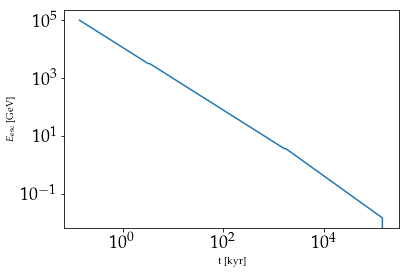

In [9]:
## Block to compute the array of escape-energies during all the stages, for ELECTRONS ##


#################
## Sedov phase ##
#################
E_esc_Sed_phase_el = np.zeros(t_range_PDS_index)
E_esc_Sed_phase_el[0] = E_min_escape_el

for i in range(1, t_range_PDS_index):
    
    E_esc_Sed_phase_el[i] = E_esc_Sed_phase_el[i-1] * (t_range_release[t_range_Sed_index + i] / t_range_release[t_range_Sed_index + (i-1)])**delta_SedPDS_el
    


#################################
## Pressure-driven phase (PDS) ##
#################################
E_esc_PDS_phase_el = np.zeros(t_range_MCS_index - t_range_PDS_index)

E_esc_PDS_phase_el[0] = E_esc_Sed_phase_el[-1]
for i in range (1, t_range_MCS_index - t_range_PDS_index):
    
    E_esc_PDS_phase_el[i] = E_esc_PDS_phase_el[i-1] * (t_range_release[t_range_PDS_index + i] / t_range_release[t_range_PDS_index + (i-1)])**delta_PDSMCS_el



#######################################
## Momentum-conservation phase (MCS) ##
#######################################
E_esc_MCS_phase_el = np.zeros(t_range_merge_index - t_range_MCS_index + 1)

E_esc_MCS_phase_el[0] = E_esc_PDS_phase_el[-1]
for i in range (1, t_range_merge_index - t_range_MCS_index):
    
    E_esc_MCS_phase_el[i] = E_esc_MCS_phase_el[i-1] * (t_range_release[t_range_MCS_index + i] / t_range_release[t_range_MCS_index + (i-1)])**delta_MCSMerge_el



# Concatenate the three energy arrays #
Escape_energy_vs_time_el = np.concatenate([E_esc_Sed_phase_el, E_esc_PDS_phase_el, E_esc_MCS_phase_el], axis=None)


plt.loglog(t_range_release, Escape_energy_vs_time_el)
plt.xlabel('t [kyr]')
plt.ylabel('$E_{\mathrm{esc}}$ [GeV]')

# <center>Propagated spectrum 

### $\bullet$ Equation $\&$ General Solution:

$$\begin{align}
&\frac{\partial f(E,t,r)}{\partial t} = \frac{D(E)}{r^2} \frac{\partial}{\partial r} r^2 \frac{\partial f}{\partial r} + \frac{\partial}{\partial E} (b(E) f) + Q \quad \Rightarrow \\[10 pt]
&\Rightarrow \quad f(r,t,E) = \frac{Q(E_{\textrm{t}}) b(E_{\textrm{t}})}{\pi^{3/2} b(E) r^3_{\textrm{diff}}} \cdot e^{-\frac{r^2}{r^2_{\textrm{diff}}}}
\end{align}$$


### $\bullet$ Solution for decaying luminosity:

$$\begin{align}
&f(r,t_{\mathrm{age}},E) = \int_{t_{\mathrm{rel}}}^{t_{\mathrm{age}}} dt' \frac{S(E_{\mathrm{t'}}) L(t') }{\pi^{3/2} r_{\mathrm{diff}}^3(E,E_{\mathrm{t'}})} \cdot \frac{b(E_{\mathrm{t'}})}{ b(E)} \cdot e^{-\frac{r^2}{r^2_{\mathrm{diff}}}} \\[10 pt]
&E_{\textrm{t}} = \mathrm{starting \, energy, \,given \, the \, loss \, equation} \\[10 pt]
&r^2_{\textrm{diff}} (E_{\textrm{t}},E) \equiv 4 \int_{E_{\textrm{t}}}^{E} \frac{D(E')}{b(E')} dE' = 4 D_0 E_0 \int_{E_t/E_0}^{E/E_0} \frac{\omega^{\delta(\omega)}}{b(\omega)} \, d \omega \\[10 pt]
&L(t) = \frac{ L_0 }{ \left(  1 + \frac{t}{\tau_{\text{d}}}  \right)^{\alpha_{\text{d}}}}
\end{align}$$

### $\bullet$ [Tomassetti, APJ vol. 752, n. 1 (2012)] ###
    
$$
\begin{align}
&\delta(\rho) \approx \delta_{\mathrm{high}} + \frac{\Delta}{1 + \frac{\xi}{1 - \xi} \left( \frac{\rho}{\rho_0} \right)^{\Delta}} \\[10 pt]
&\delta_{\mathrm{high}} = 1/6, \qquad \Delta = 0.55, \qquad \rho_0 = 2 \, \mathrm{GV}, \qquad \xi = 0.1 \\[10 pt]
&\rho = \frac{\sqrt{E_{k}^2 + 2 m_p E_{k}}}{Z}, \qquad E_{k} = \sqrt{(ZR)^2 + m_p^2} - m_p, \qquad E_{k} \equiv \mathrm{kinetic \; energy \; per \; nucleon.} 
\end{align}
$$

Minimum slope for D(E): 0.17965663594467232
Maximum slope for D(E): 0.6659884342071402



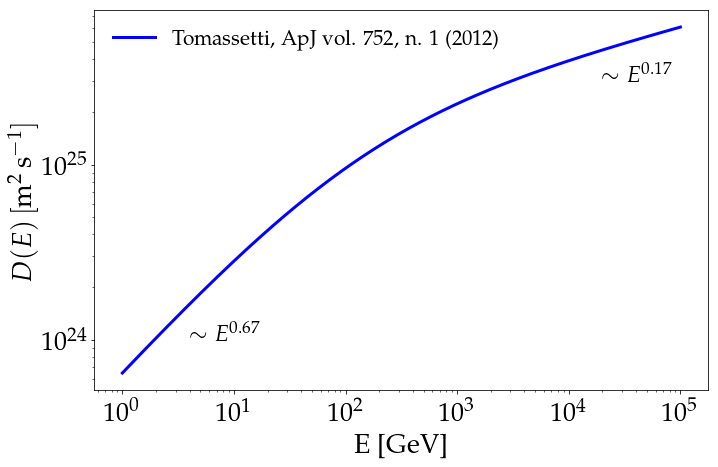

In [11]:
### Building the diffusion coefficient from Tomassetti THMb ###

rigidity_array_D = np.sqrt(E_e**2 + 2*m_p * E_e)


### Parameters to implement the variable slope from Tomassetti ###
##################################################################
ref_rigidity_tomassetti = 2.     # in [GV]
delta_HIGH_tomassetti = 1./6.
Delta_tomassetti = 0.55
csi_tomassetti = 0.1
ref_E_0 = 1.                     # in [GeV]: D(E) = D_0 (E/E_0)^delta

ref_energy_tomassetti = np.sqrt(ref_rigidity_tomassetti**2 + m_p**2) - m_p   # in [GeV]


delta_tomassetti_variable = delta_HIGH_tomassetti + Delta_tomassetti / ( 1 + ( csi_tomassetti/(1-csi_tomassetti) ) * pow( rigidity_array_D[:len(E_e)-1] / ref_rigidity_tomassetti, Delta_tomassetti) )                
print ("Minimum slope for D(E):", min(delta_tomassetti_variable))
print ("Maximum slope for D(E):", max(delta_tomassetti_variable))
print ("")


D_0_low = D_0_yr/conv_factor_yr_to_sec * (min(E_e) / ref_E_0)**(max(delta_tomassetti_variable))


D_next = np.zeros(len(E_e))
for iD in range(len(E_e)):
    if iD == 0:
        D_next[iD] = D_0_low
    else:
        D_next[iD] = D_next[iD-1] * (E_e[iD] / E_e[iD-1])**delta_tomassetti_variable[iD-1]

    
D_next_function = interpolate.interp1d(E_e, D_next, kind='cubic', bounds_error=False)

##################################################################


plt.figure(figsize=(11,7))


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=26)
ax.tick_params(axis='both', which='minor', labelsize=26)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7



plt.loglog(E_e, D_next_function(E_e), lw=3, label='Tomassetti, ApJ vol. 752, n. 1 (2012)', color='blue')
plt.text(4, 1.e+24, '$\sim E^{0.67}$', fontsize=23)
plt.text(2.e+4, 3.e+25, '$\sim E^{0.17}$', fontsize=23)
plt.legend(frameon=False, fontsize = 21)
plt.xlabel('E [GeV]', fontsize=27)
plt.ylabel('$D(E) \, \mathrm{[m^2 \, s^{-1}]}$', fontsize=27)


plt.savefig('Diffusion_coefficient_Tomassetti.pdf',format='pdf',bbox_inches='tight', dpi=200)

In [12]:
#############################
# Calculating the integrand #
#############################


start = time.process_time()


steps_t_integral = 1000   # 40000, to make the high-energy wiggles disappear
int_var_length = 100

result_integrand_matrix = np.zeros( (  considered_objects,len(E_e),steps_t_integral  ) )
t_integral = np.zeros( (considered_objects, steps_t_integral) )

for i in range(considered_objects):

    print ("I am examining the object",object_name[i])
    r[i] = r_kpc[i]*1000*conv_factor_pc_to_m    # distance of the object, in [m]

    

#######################################################################################################
# given the parameters found for the specfic object, I now define the functions plotting the spectrum #
#######################################################################################################

    start_time = 1.
    stop_time = object_age[i]
    t_integral[i] = np.logspace(np.log10(start_time), np.log10(stop_time), num=steps_t_integral, endpoint=True)  # time-step, in [yr]


###### Section dedicated to the calculation of the integral giving the spectrum #######


## The following matrix keeps track of the different instants of life (along the columns) of the particles of a certain measured energy (in the rows) ##
    E_t_prime_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    numerator_no_loss_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    loss_ratio_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    exponential_factor_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    denominator_matrix = np.zeros( (  len(E_e),len(t_integral[i])  ) )
    
    
    ## Calculation of the diffusive distance with variable delta ##
    ###############################################################
    integrand = np.zeros( (len(E_e), len(t_integral[i]), int_var_length) )
    r_diff_square_variable = np.zeros( (len(E_e), len(t_integral[i])) )
    
    
    for ie in range(len(E_e)):
        
        index_current_energy = np.argmin(abs(E_e[ie] - ODE_sol_array))
        
        for it in range(len(t_integral[i])):
            
            
            current_t = time_ODE[index_current_energy]
            delta_t = abs(object_age[i] - t_integral[i][it])
            target_t = current_t - delta_t
            target_t_index = np.argmin(abs(target_t - time_ODE))
            

            if (1 - b_0_yr * (object_age[i] - t_integral[i][it]) * ODE_sol_array[index_current_energy] > 0.):
                
                E_t_prime_matrix[ie][it] = ODE_sol_array[target_t_index]
                integration_variable = np.zeros(int_var_length)
                min_integration_variable = E_t_prime_matrix[ie][it] / ref_E_0
                integration_variable = np.logspace(np.log10(min_integration_variable), np.log10(ODE_sol_array[index_current_energy]/ref_E_0), num=int_var_length)
                
                integrand[ie][it] = (D_next_function(integration_variable)/conv_factor_sec_to_yr) / loss_rate_KN(integration_variable * ref_E_0)
                r_diff_square_variable[ie][it] = 4 * integrate.trapz(integrand[ie][it], integration_variable)
                
                #integrand[ie][it] = diffusione(integration_variable) / loss_rate_KN(integration_variable * ref_E_0)
                #r_diff_square_variable[ie][it] = (4 * D_0_yr_SBPL * ref_E_0) * integrate.trapz(integrand[ie][it], integration_variable)
    ###############################################################
    

    for e in range(len(E_e)):

        index_current_energy = np.argmin(abs(E_e[e] - ODE_sol_array))
        
        ## When this energy is released
        t_rel_E = t_range_release[np.argmin(abs(ODE_sol_array[index_current_energy] - Escape_energy_vs_time_el))]

        for t in range(len(t_integral[i])):

            
            current_t = time_ODE[index_current_energy]
            delta_t = abs(object_age[i] - t_integral[i][t])
            target_t = current_t - delta_t
            target_t_index = np.argmin(abs(target_t - time_ODE))


            if (1 - b_0_yr * ( object_age[i] - t_integral[i][t] ) * ODE_sol_array[index_current_energy]) > 0.:

                E_t_prime_matrix[e][t] = ODE_sol_array[target_t_index]

                if E_t_prime_matrix[e][t] != 0.:

                    if r_diff_square_variable[e][t] != 0.:
                        
                        numerator_no_loss_matrix[e][t] = N_0 * pow( E_t_prime_matrix[e][t] , -gamma_inj ) * ( 1 / pow( 1 + t_integral[i][t]/(tau_dec[i]) , alpha_dec[i]) )
                        loss_ratio_matrix[e][t] = loss_rate_KN(E_t_prime_matrix[e][t] * ref_E_0) / loss_rate_KN(ODE_sol_array[index_current_energy] * ref_E_0)
                        exponential_factor_matrix[e][t] = np.exp( - pow( r[i], 2) / r_diff_square_variable[e][t] )
                        denominator_matrix[e][t] = pow( pi * r_diff_square_variable[e][t] , 3/2 )

                        if (t_integral[i][t] >= t_rel_E*1.e+3):
                            result_integrand_matrix[i][e][t] = (tau_dec[i]) * (c/(4*pi)) * (numerator_no_loss_matrix[e][t] * loss_ratio_matrix[e][t] * exponential_factor_matrix[e][t]) / denominator_matrix[e][t]  

                            
print (time.process_time() - start, "seconds")  

## Now I have an integrand matrix that contains the current energy-values in the rows and the different release-times in the columns ##


I am examining the object Sample 1
I am examining the object Sample 2
I am examining the object Sample 3
287.380045 seconds


/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


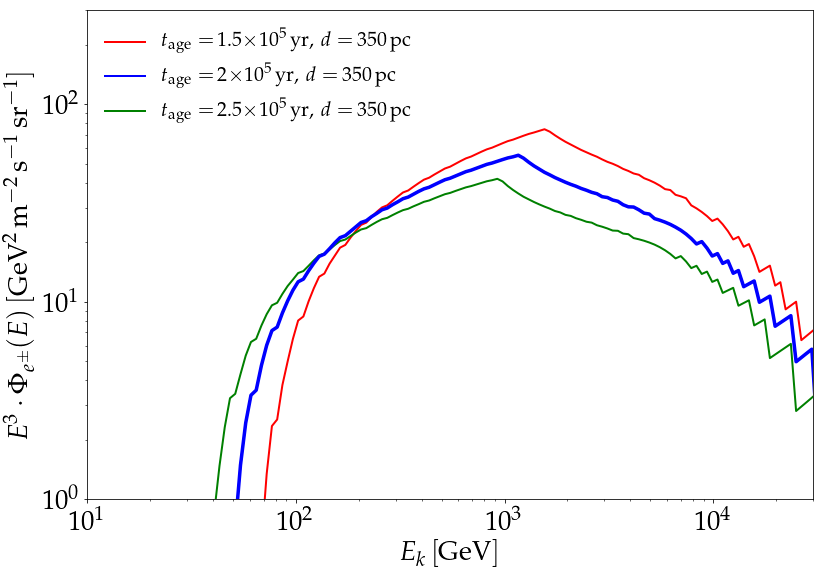

In [13]:
plt.figure(figsize=(13,9))


J_e = np.zeros( (considered_objects,len(E_e)) )  

for i in range(considered_objects):
    for e in range(len(E_e)):
        J_e[i][e] = integrate.trapz(result_integrand_matrix[i][e], t_integral[i]/(tau_dec[i]))



f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))
object_age_latex = []
for i in range(considered_objects):
    object_age_latex.append("${}$".format(f.format_data(object_age[i])))
    

legend_label = []
for i in range(considered_objects):
    legend_label.append( '$t_{\mathrm{age}} = \,$' + str(object_age_latex[i]) + '$\, \mathrm{yr}, \, d = \,$' + str(int(r_kpc[i]*1000)) + '$\, \mathrm{pc}$')

        
for i in range(considered_objects):
    plt.plot(E_e, J_e[i]*(E_e**3)*conv_factor_yr_to_sec, lw=2, color=multiplot_color[i], label=legend_label[i])
        
plt.plot(E_e, J_e[1]*(E_e**3)*conv_factor_yr_to_sec, lw=3.5, color='blue')   # mark the second curve



ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7



### Plot cosmetics ###
leg = plt.legend(fontsize = 20, frameon=True, framealpha=0.9, facecolor='white', edgecolor='white', loc='best')


plt.axis([1.e1,3.e4, 1.e0,3.e2],interpolation='none')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{k} \, [\mathrm{GeV}]$',fontsize=27)
plt.ylabel(r'$E^{3} \cdot \Phi_{e^{\pm}}(E) \, [\mathrm{GeV}^2 \, \mathrm{m}^{-2} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1}]$',fontsize=27)


plt.savefig('Electrons_DifferentAges_VariableDelta_KN_EnDepRelease.pdf',format='pdf',bbox_inches='tight', dpi=200)


# <center>Total energy budget of the source
    
$$
\begin{align}
E_{\mathrm{tot}} &= \int d^3 \vec{r} \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}} dt \int_0^{+ \infty} dE \, E \cdot Q(E, \vec{r}, t), \qquad \qquad \qquad Q(E, \vec{r}, t) = S_0 \left( \frac{E}{E_0} \right)^{-\Gamma_{\mathrm{inj}}} \, \delta(\vec{r}) \, L(t) \\[10 pt]
&= L_0 \, E_0^2 \, S_0 \cdot \tau_{\mathrm{d}} \int^{+ \infty}_{0} d\omega \cdot \omega^{-\Gamma_{\mathrm{inj}} + 1 }  \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}(\omega)} dz \, \frac{1}{\left( 1 + z \right)^{\alpha}} \\[10 pt]
&= N_0 \cdot \tau_{\mathrm{d}} \int^{+ \infty}_{0} d\omega \cdot \omega^{-\Gamma_{\mathrm{inj}} + 1 } \int^{t_{\mathrm{age}}}_{t_{\mathrm{rel}}(\omega)} dz \, \frac{1}{\left( 1 + z \right)^{\alpha}}
\end{align}
$$

In [14]:
def f_time(z, alpha_var):
    return pow(1 + z, -alpha_var)



integration_var_omega = np.logspace(np.log10(1./ref_E_0), np.log10(max(E_e)/ref_E_0), num=len(E_e))
integrand_temp = np.zeros( (considered_objects,len(E_e)) )
integrand_omega = np.zeros( (considered_objects,len(E_e)) )
t_rel_E_omega = np.zeros(len(E_e))


for ic in range(considered_objects):

    for ie in range(len(E_e)):

        integrand_temp[ic][ie] = integration_var_omega[ie]**(-gamma_inj + 1)
        
        ## When this energy is released
        t_rel_E_omega[ie] = t_range_release[np.argmin(abs(E_e[ie] - Escape_energy_vs_time_el))]*1.e+3

        integral_time, error_time = integrate.quad(f_time, t_rel_E_omega[ie]/tau_dec[ic], object_age[ic]/tau_dec[ic], args=alpha_dec[ic])

        if (t_rel_E_omega[ie]/tau_dec[ic] < object_age[ic]/tau_dec[ic]):
            integrand_omega[ic][ie] = integrand_temp[ic][ie] * integral_time
            

            
Energy_budget_EnDepRelease = np.zeros(considered_objects)         
for ic in range(considered_objects):
    
    Energy_budget_EnDepRelease[ic] = N_0 * tau_dec[ic]*conv_factor_yr_to_sec * integrate.trapz(integrand_omega[ic], integration_var_omega)
    print ('Energy budget in electrons of object', ic, '=', Energy_budget_EnDepRelease[ic]*conv_factor_GeV_to_erg, '[erg]')


Energy budget in electrons of object 0 = 8.357229523844477e+47 [erg]
Energy budget in electrons of object 1 = 1.0149253786212213e+48 [erg]
Energy budget in electrons of object 2 = 1.1587921642888901e+48 [erg]
